# GWAS with PLINK and R

## Installation
Optional: One could additionally install **HaploView** from https://sourceforge.net/projects/haploview/ and **gPLINK** from https://zzz.bwh.harvard.edu/plink/dist/gPLINK-2.050.zip

In [20]:
sudo apt install plink1.9

Reading package lists... 0%Reading package lists... 100%Reading package lists... Done
Building dependency tree... 0%Building dependency tree... 0%Building dependency tree... 50%Building dependency tree... 50%Building dependency tree... Done
Reading state information... 0% Reading state information... 0%Reading state information... Done
plink1.9 is already the newest version (1.90~b6.21-201019-1).
The following packages were automatically installed and are no longer required:
  dzen2 libfakekey0 libfltk1.3 libiw30 matchbox-common matchbox-desktop
  matchbox-keyboard matchbox-keyboard-im matchbox-panel matchbox-panel-manager
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In R install **qqman** with `install.packages("qqman")`

## Data

download example dataset by Shaun Purcell, however, it is also provided in this repository

In [1]:
# wget https://zzz.bwh.harvard.edu/plink/dist/example.zip

In [2]:
pwd

/home/ubuntu/CompBiol3/GWAS


In [3]:
ls -l

total 87288
drwxrwxr-x 2 ubuntu ubuntu     4096 Feb 25 10:49 Playground
drwxrwxr-x 3 ubuntu ubuntu     4096 Feb 25 10:09 ShaunPurcell
-rw-rw-r-- 1 ubuntu ubuntu     1064 Feb 25 10:49 gwas.ipynb
-rw-r--r-- 1 ubuntu ubuntu  7033003 Feb 25 10:52 gwas.org.map
-rw-r--r-- 1 ubuntu ubuntu 82332090 Feb 25 10:52 gwas.org.ped


## Processing

Initial creation of a binary dataset from raw genotype data for faster data access

In [21]:
plink1.9 --file gwas.org --make-bed --out gwas.bin --gplink

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [22]:
cat gwas.bin.log

PLINK v1.90b6.22 64-bit (3 Nov 2020)
Options in effect:
  --file gwas.org
  --gplink
  --make-bed
  --out gwas.bin

Hostname: rw20G
Working directory: /home/ubuntu/CompBiol3/GWAS
Start time: Sun Feb 25 12:06:48 2024

Random number seed: 1708859208
15983 MB RAM detected; reserving 7991 MB for main workspace.
Scanning .ped file... done.
Performing single-pass .bed write (228694 variants, 90 people).
--file: gwas.bin-temporary.bed + gwas.bin-temporary.bim +
gwas.bin-temporary.fam written.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
90 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 90 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.993346.
228694 variants and 90 people pass filters and QC.
Among remaining phenotypes, 49 are cases and 41 are controls.
--make-bed to gwas.bin.bed + gwas.bin.bim + gwas.bin.fam ... done.

E

### Validate converted data

In [23]:
plink1.9 --bfile gwas.bin --out validate --gplink

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


: 10

### Calculate Hardy-Weinberg

In [24]:
plink1.9 --bfile gwas.bin --hardy --out hardy --gplink

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [25]:
cat hardy.log

PLINK v1.90b6.22 64-bit (3 Nov 2020)
Options in effect:
  --bfile gwas.bin
  --gplink
  --hardy
  --out hardy

Hostname: rw20G
Working directory: /home/ubuntu/CompBiol3/GWAS
Start time: Sun Feb 25 12:37:57 2024

Random number seed: 1708861077
15983 MB RAM detected; reserving 7991 MB for main workspace.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
90 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 90 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.993346.
--hardy: Writing Hardy-Weinberg report (founders only) to hardy.hwe ... done.

End time: Sun Feb 25 12:37:57 2024


In [26]:
head hardy.hwe

 CHR         SNP     TEST   A1   A2                 GENO   O(HET)   E(HET)            P 
   1   rs3094315      ALL    G    A              0/22/67   0.2472   0.2166       0.3476
   1   rs3094315      AFF    G    A              0/15/33   0.3125   0.2637       0.5771
   1   rs3094315    UNAFF    G    A               0/7/34   0.1707   0.1562            1
   1   rs6672353      ALL    A    G               0/1/88  0.01124  0.01117            1
   1   rs6672353      AFF    A    G               0/1/48  0.02041   0.0202            1
   1   rs6672353    UNAFF    A    G               0/0/40        0        0            1
   1   rs4040617      ALL    G    A              0/21/69   0.2333   0.2061       0.5994
   1   rs4040617      AFF    G    A              0/14/35   0.2857   0.2449       0.5714
   1   rs4040617    UNAFF    G    A               0/7/34   0.1707   0.1562            1


In [27]:
head hardy.gplink

0


### Filter Hardy
Filter for controls (TEXT=="UNAFF") and p-values <= 0.001

In [43]:
awk '$3=="UNAFF" && $9<=0.001{print $0}' hardy.hwe | sort -g -k 9 | head -3

  15   rs7178071    UNAFF    G    A               6/3/32  0.07317   0.2989    2.377e-05
  14   rs1242105    UNAFF    C    T               4/1/36  0.02439   0.1954    2.557e-05
   4   rs1392554    UNAFF    T    C              12/7/22   0.1707   0.4703    4.385e-05


### Create QC-filtered Dataset

In [46]:
plink1.9 --maf 0.01 --geno 0.05 --mind 0.05 --hwe 0.001 --bfile gwas.bin --make-bed --out gwas.bin.filtered --gplink

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [47]:
cat gwas.bin.filtered.log

PLINK v1.90b6.22 64-bit (3 Nov 2020)
Options in effect:
  --bfile gwas.bin
  --geno 0.05
  --gplink
  --hwe 0.001
  --maf 0.01
  --make-bed
  --mind 0.05
  --out gwas.bin.filtered

Hostname: rw20G
Working directory: /home/ubuntu/CompBiol3/GWAS
Start time: Mon Feb 26 11:16:07 2024

Random number seed: 1708942567
15983 MB RAM detected; reserving 7991 MB for main workspace.
228694 variants loaded from .bim file.
90 people (45 males, 45 females) loaded from .fam.
90 phenotype values loaded from .fam.
1 person removed due to missing genotype data (--mind).
ID written to gwas.bin.filtered.irem .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 89 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate in remaining samples is 0.995473.
2728 variants removed due to missing genotype data (--geno).
--hwe: 69 variants removed due to Hardy-Weinberg exact test.
46404 variants removed due to minor allele threshold(s)
(--ma

### Perform Basic Association Analysis of QC-Dataset

In [48]:
plink1.9 --bfile gwas.bin.filtered --assoc --adjust --out gwas.bin.filtered.assoc --gplink

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [49]:
cat gwas.bin.filtered.assoc.log

PLINK v1.90b6.22 64-bit (3 Nov 2020)
Options in effect:
  --adjust
  --assoc
  --bfile gwas.bin.filtered
  --gplink
  --out gwas.bin.filtered.assoc

Hostname: rw20G
Working directory: /home/ubuntu/CompBiol3/GWAS
Start time: Mon Feb 26 11:24:01 2024

Random number seed: 1708943041
15983 MB RAM detected; reserving 7991 MB for main workspace.
179493 variants loaded from .bim file.
89 people (44 males, 45 females) loaded from .fam.
89 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 89 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.996308.
179493 variants and 89 people pass filters and QC.
Among remaining phenotypes, 48 are cases and 41 are controls.
Writing C/C --assoc report to gwas.bin.filtered.assoc.assoc ...
done.
--adjust: Genomic inflation est. lambda (based on median chisq) = 1.25937.
--adjust values (179493 variants) written to
gwas.bin.filtered.assoc.asso

In [50]:
head -3 gwas.bin.filtered.assoc.assoc gwas.bin.filtered.assoc.assoc.adjusted

==> gwas.bin.filtered.assoc.assoc <==
 CHR         SNP         BP   A1      F_A      F_U   A2        CHISQ            P           OR 
   1   rs3094315     792429    G   0.1489  0.08537    A        1.684       0.1944        1.875 
   1   rs4040617     819185    G   0.1354  0.08537    A        1.111       0.2919        1.678 

==> gwas.bin.filtered.assoc.assoc.adjusted <==
 CHR         SNP      UNADJ         GC       BONF       HOLM   SIDAK_SS   SIDAK_SD     FDR_BH     FDR_BY
  11   rs2513514  4.693e-07  7.131e-06    0.08423    0.08423    0.08078    0.08078    0.06375      0.808 
  20   rs6110115  7.103e-07  9.938e-06     0.1275     0.1275     0.1197     0.1197    0.06375      0.808 


In [51]:
wc -l gwas.bin.filtered.assoc.assoc gwas.bin.filtered.assoc.assoc.adjusted

  179494 gwas.bin.filtered.assoc.assoc
  179494 gwas.bin.filtered.assoc.assoc.adjusted
  358988 total


### Analyze in R
```library(qqman)
gwas<-read.table("gwas.bin.filtered.assoc.assoc", header=TRUE)
manhattan(gwas, chr="CHR", bp="BP", snp="SNP", p="P",suggestiveline=F, genomewideline=T)
as.data.frame(table(gwas$CHR)) # number of SNPs per chromosome

SNPsOfInterest<-c("rs2513514","rs6110115")
manhattan(gwas, annotatePval = 0.01, highlight=SNPsOfInterest)
manhattan(gwas, annotatePval=0.001, highlight=SNPsOfInterest)
manhattan(gwas, annotatePval=0.0001, highlight=SNPsOfInterest)
manhattan(gwas, annotatePval=0.00001, highlight=SNPsOfInterest)
```

Fuse *gwas.bin.filtered.assoc.assoc* and *gwas.bin.filtered.assoc.assoc.adjusted* with respect to column "BP"

In [56]:
awk 'BEGIN{print "CHR","BP","SNP","P","GC","BONF"}{while(getline < "gwas.bin.filtered.assoc.assoc" > 0){snp[$2]=$3}{print $1,snp[$2],$2,$3,$4,$5}}' gwas.bin.filtered.assoc.assoc.adjusted > gwas.bin.filtered.assoc.assoc.adjusted.fused

```
gwas_adj<-read.table("gwas.bin.filtered.assoc.assoc.adjusted.fused", header=TRUE)
manhattan(gwas_adj, chr="CHR", bp="BP", snp="SNP", p="P",suggestiveline=T, annotatePval=0.0001, genomewideline=T)
manhattan(subset(gwas_adj, CHR==8),xlim=c(12000000,14000000),genomewideline=T)
qq(gwas_adj$P)
```
Create plot with: `manhattan(gwas_adj, genomewideline=T, annotatePval=0.00001, annotateTop=F, highlight=gwas_adj$SNP[gwas_adj$BONF<1])`

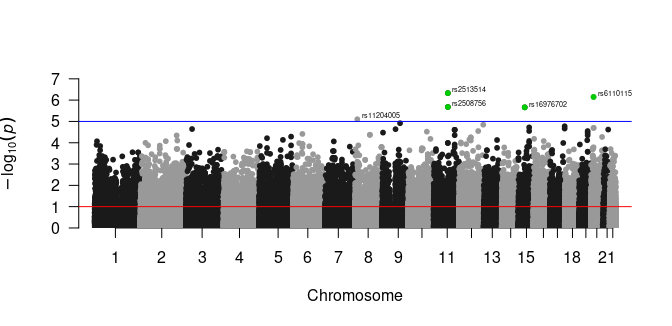

Create plot with: `manhattan(subset(gwas_adj, CHR==11),xlim=c(75000000,77000000),genomewideline=T, annotatePval=0.00001, annotateTop=F)`

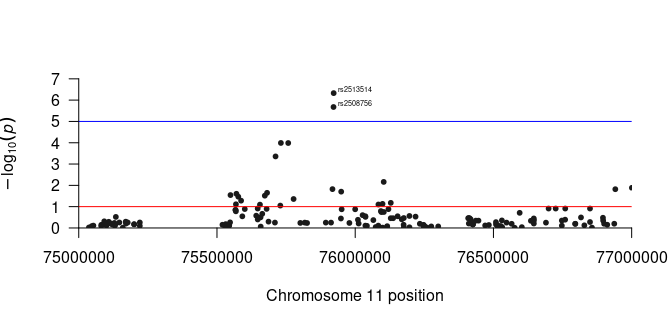

Create plot with: `manhattan(subset(gwas_adj, CHR==8),xlim=c(12000000,14000000),genomewideline=T)`

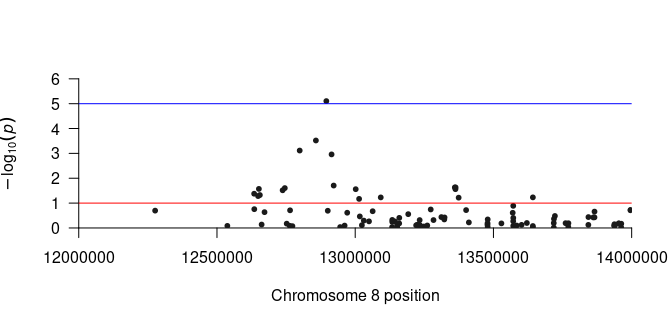

Create plot with: `qq(gwas_adj$P)`

![gwas-qq.png](attachment:b5cfb087-f75a-4729-8517-41b7

In [53]:
grep rs9616985 gwas.bin.filtered.assoc.assoc.adjusted.fused

22 49519949 rs9616985 49519949 C 0.03125
22 49519949 rs9616985 0.8441 0.8609 1


In [55]:
tail -5 gwas.bin.filtered.assoc.assoc.adjusted.fused

21 33308533 rs2211685 1 1 1
21 39412266 rs2063972 1 1 1
21 42413116 rs220148 1 1 1
22 36001892 rs2267363 1 1 1
22 37662641 rs5757391 1 1 1
